# Generate custom template library with models from the Allen Institute of Brain Science

In this notebook, we show how to build a custom template library using cell models from the Allen Institute database.

In particuar, we downloaded 3 cell models:

- [488695444](https://celltypes.brain-map.org/experiment/electrophysiology/488695444) (spiny - excitatory)
- [488680211](https://celltypes.brain-map.org/experiment/electrophysiology/488680211) (spiny - excitatory)
- [487667205](https://celltypes.brain-map.org/experiment/electrophysiology/487667205) (aspiny - inhibitory)

To get the models, select `Select neuronal model` -> `Biophysical - perisomatic` (or `Biophysical - all active`, if available), download the zip file, and unzip it in a folder with the same name as the cell (e.g. neuronal_model_491623973) in the `allen_models` folder in the working directory.


In [47]:
import MEArec as mr
import MEAutility as mu
from pathlib import Path
import neuron
import LFPy
import os
import json
import matplotlib.pylab as plt
%matplotlib notebook

We need to define a function to load the cell models in LFPy. The following function takes the cell folder as input, and it returns an `LFPy.Cell` object:

In [1]:
# function to load Allen cells in LFPy
def return_allen_cell(cell_model_folder, dt=2**-5, start_T=0, end_T=1):
    cell_model_folder = Path(cell_model_folder)
    cwd = os.getcwd()
    os.chdir(cell_model_folder)
    
    # compile mechanisms
    mod_folder = "modfiles"
    os.chdir(mod_folder)
    os.system('nrnivmodl')
    os.chdir('..')
    neuron.load_mechanisms(mod_folder)
    params = json.load(open("fit_parameters.json", 'r'))

    celsius = params["conditions"][0]["celsius"]
    reversal_potentials = params["conditions"][0]["erev"]
    v_init = params["conditions"][0]["v_init"]
    active_mechs = params["genome"]
    neuron.h.celsius = celsius

    cell_parameters = {
        'morphology': 'reconstruction.swc',
        'v_init': v_init,  # initial membrane potential
        'passive': False,  # turn on NEURONs passive mechanism for all sections
        'nsegs_method': 'lambda_f',  # spatial discretization method
        'lambda_f': 200.,  # frequency where length constants are computed
        'dt': dt,  # simulation time step size
        'tstart': start_T,  # start time of simulation, recorders start at t=0
        'tstop': end_T,  # stop simulation at 100 ms.
    }

    cell = LFPy.Cell(**cell_parameters)

    for sec in neuron.h.allsec():
        sec.insert("pas")
        sectype = sec.name().split("[")[0]
        for sec_dict in active_mechs:
            if sec_dict["section"] == sectype:
                # print(sectype, sec_dict)
                if not sec_dict["mechanism"] == "":
                    sec.insert(sec_dict["mechanism"])
                exec ("sec.{} = {}".format(sec_dict["name"], sec_dict["value"]))

        for sec_dict in reversal_potentials:
            if sec_dict["section"] == sectype:
                # print(sectype, sec_dict)
                for key in sec_dict.keys():
                    if not key == "section":
                        exec ("sec.{} = {}".format(key, sec_dict[key]))
    
    os.chdir(cwd)

    return cell

In [33]:
def plot_cell_projections(cell):
    fig = plt.figure()
    ax_xy = fig.add_subplot(2,2,1)
    ax_xz = fig.add_subplot(2,2,2)    
    ax_yz = fig.add_subplot(2,2,3)    
    
    for i, (xs, xe, ys, ye, zs, ze) in enumerate(zip(cell.xstart, cell.xend, cell.ystart, cell.yend, cell.zstart, cell.zend)):
        if i in cell.get_idx('soma'):
            ax_xy.plot([xs, xe], [ys, ye], color='k', lw=5)
            ax_xz.plot([xs, xe], [zs, ze], color='k', lw=5)
            ax_yz.plot([ys, ye], [zs, ze], color='k', lw=5)
        else:
            ax_xy.plot([xs, xe], [ys, ye], color='k')
            ax_xz.plot([xs, xe], [zs, ze], color='k')
            ax_yz.plot([ys, ye], [zs, ze], color='k')
        
    ax_xy.axis('equal')
    ax_xz.axis('equal')
    ax_yz.axis('equal')
    ax_xy.set_xlabel('x')
    ax_xy.set_ylabel('y')
    ax_xz.set_xlabel('x')
    ax_xz.set_ylabel('z')
    ax_yz.set_xlabel('y')
    ax_yz.set_ylabel('z')

    return fig

In [43]:
cell_folder = 'allen_models/neuronal_model_489932682/'

In [6]:
cell = return_allen_cell(cell_folder)

<IPython.core.display.Javascript object>


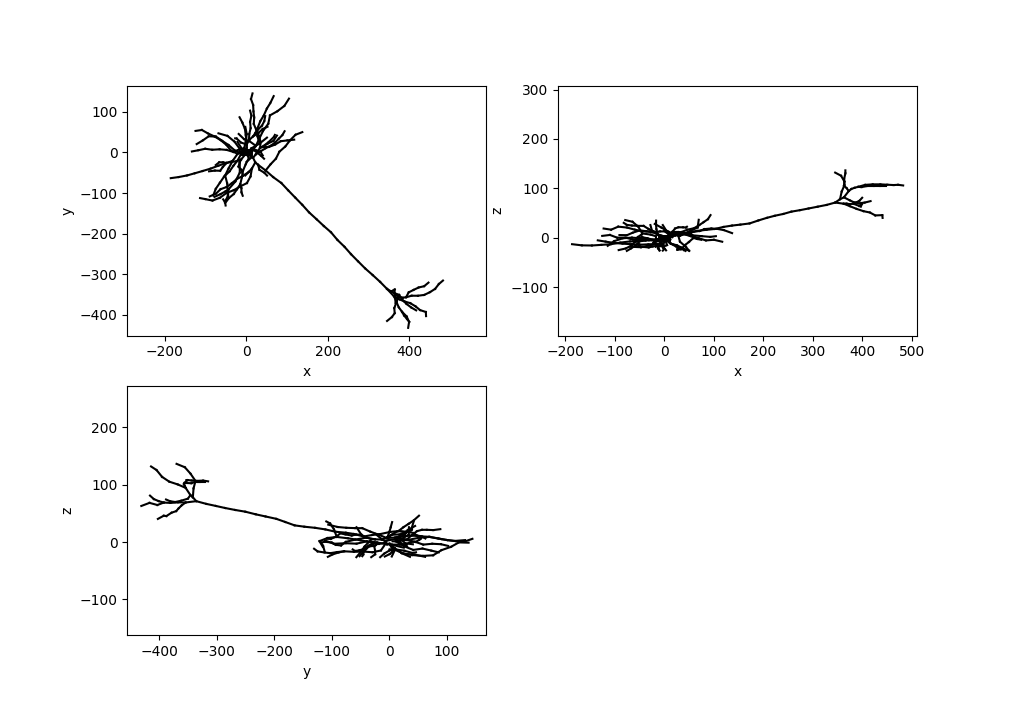

In [38]:
fig = plot_cell_projections(cell)

In [51]:
template_params = mr.get_default_templates_params()
template_params['seed'] = 0
template_params['rot'] = 'norot'

In [12]:
print(template_params)

{'sim_time': 1, 'target_spikes': [3, 50], 'cut_out': [2, 5], 'dt': 0.03125, 'delay': 10, 'weights': [0.25, 1.75], 'rot': 'physrot', 'probe': 'Neuronexus-32', 'ncontacts': 10, 'overhang': 30, 'offset': 0, 'xlim': [10, 80], 'ylim': None, 'zlim': None, 'min_amp': 30, 'n': 50, 'seed': 0, 'drifting': False, 'max_drift': 100, 'min_drift': 30, 'drift_steps': 30, 'drift_xlim': [-10, 10], 'drift_ylim': [-10, 10], 'drift_zlim': [20, 80]}


In [45]:
mr.run_cell_model(cell_folder, sim_folder='sim', verbose=True, save=True, return_vi=True, custom_return_cell_function=return_allen_cell, **template_params)

Mechanisms already loaded from path: modfiles.  Aborting.
Input weight:  0.25  - Num Spikes:  13


<IPython.core.display.Javascript object>


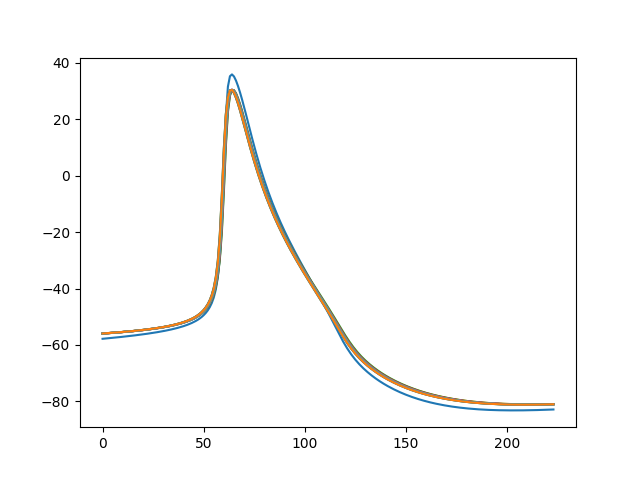

In [39]:
plt.figure()
_ = plt.plot(v.T)

In [40]:
len(cell.xmid)

283

In [52]:
mr.calc_extracellular(cell_folder, "allen", "sim", verbose=True, 
                      custom_return_cell_function=return_allen_cell, **template_params)

norot
Mechanisms already loaded from path: modfiles.  Aborting.
Cell    extracellular spikes to be simulated
Cell:  Progress: [1/50]


/home/alessiob/.virtualenvs/mearec/lib/python3.6/site-packages/LFPy/recextelectrode.py:317: UserWarning: Membrane currents do not sum to zero
  warnings.warn('Membrane currents do not sum to zero')


Cell:  Progress: [2/50]
Cell:  Progress: [3/50]
Cell:  Progress: [4/50]
Cell:  Progress: [5/50]
Cell:  Progress: [6/50]
Cell:  Progress: [7/50]
Cell:  Progress: [8/50]
Cell:  Progress: [9/50]
Cell:  Progress: [10/50]
Cell:  Progress: [11/50]
Cell:  Progress: [12/50]
Cell:  Progress: [13/50]
Cell:  Progress: [14/50]
Cell:  Progress: [15/50]
Cell:  Progress: [16/50]
Cell:  Progress: [17/50]
Cell:  Progress: [18/50]
Cell:  Progress: [19/50]
Cell:  Progress: [20/50]
Cell:  Progress: [21/50]
Cell:  Progress: [22/50]
Cell:  Progress: [23/50]
Cell:  Progress: [24/50]
Cell:  Progress: [25/50]
Cell:  Progress: [26/50]
Cell:  Progress: [27/50]
Cell:  Progress: [28/50]
Cell:  Progress: [29/50]
Cell:  Progress: [30/50]
Cell:  Progress: [31/50]
Cell:  Progress: [32/50]
Cell:  Progress: [33/50]
Cell:  Progress: [34/50]
Cell:  Progress: [35/50]
Cell:  Progress: [36/50]
Cell:  Progress: [37/50]
Cell:  Progress: [38/50]
Cell:  Progress: [39/50]
Cell:  Progress: [40/50]
Cell:  Progress: [41/50]
Cell:  P